In [253]:
import pandas as pd
import warnings
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA


import warnings
import itertools
warnings.filterwarnings("ignore")

# Data Transformation from milestone 1 - Preparing the data for milestone 2
df = pd.read_excel('MER_T12_06.xlsx')

df['Date'] = df['YYYYMM'].apply(lambda x: pd.to_datetime(x, format = '%Y%m', errors ='coerce'))
df.dropna(inplace = True)
df['Value_num'] = pd.to_numeric(df["Value"], errors = 'coerce')
df['Value_num'] = df["Value_num"].fillna(0)
t = df['Description'].drop_duplicates().reset_index(drop = True)

dic ={}
dic[t[0]] = 'Coal'
dic[t[1]] = 'Natural Gas'
dic[t[2]] = 'Distillate Fuel'
dic[t[3]] = 'Petroleum Coke'
dic[t[4]] = 'Residual Fuel Oil'
dic[t[5]] = 'Petroleum'
dic[t[6]] = 'Geothermal Energy'
dic[t[7]] = 'Non Biomass Waste'
dic[t[8]] = 'Total'

df['Fuel Type'] = df['Description'].apply(lambda x: dic[x])

dff = df[df['Fuel Type'] == 'Natural Gas'].reset_index(drop = True)
dff = dff[['Date','Value_num']]
dff = dff.set_index(keys='Date')

# Simplified data which only contains CO2 emission by Natural Gas and date 
dff.head(10)

,Value_num
Date,
1973-01-01,12.175
1973-02-01,11.708
1973-03-01,13.994
1973-04-01,14.627
1973-05-01,17.344
1973-06-01,20.265
1973-07-01,23.067
1973-08-01,22.850
1973-09-01,19.297


<AxesSubplot:xlabel='Date', ylabel='Value_num'>

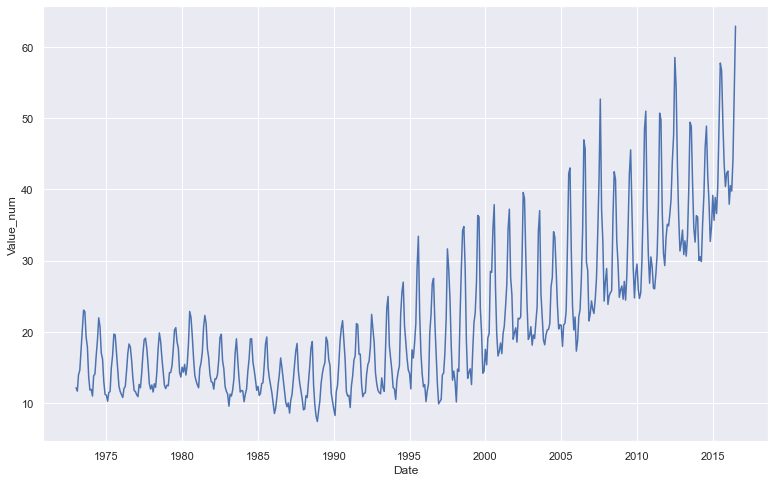

In [254]:
sns.set(rc={'figure.figsize':(13,8)})
sns.lineplot(data = dff, x ="Date", y = 'Value_num')

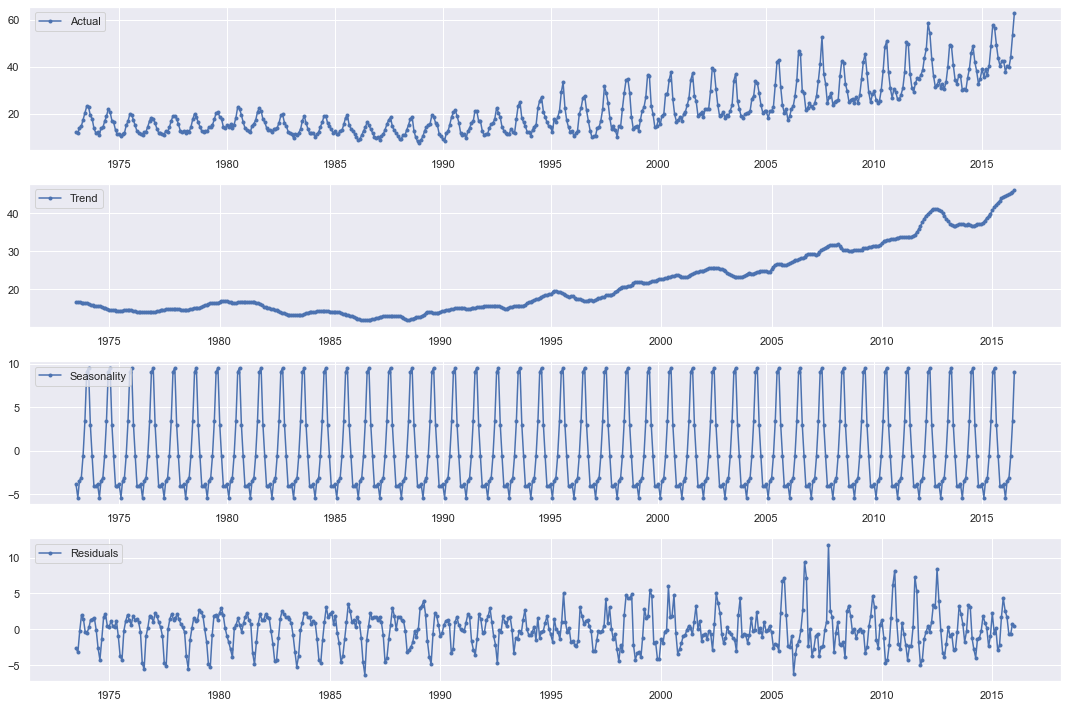

In [255]:
#Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(dff)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(dff, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observation**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **there is a clear annual seasonality in the data.**
- We can confirm that **the series is not stationary.**

In [256]:
# Splitting the data into train and test (24 months for test data set)
df_train, df_test = dff[(dff.index< '2014-8-1')], dff[dff.index >= '2014-8-1']
print(df_train.shape)
print(df_test.shape)

(499, 1)
(24, 1)


### **Making the series stationary**

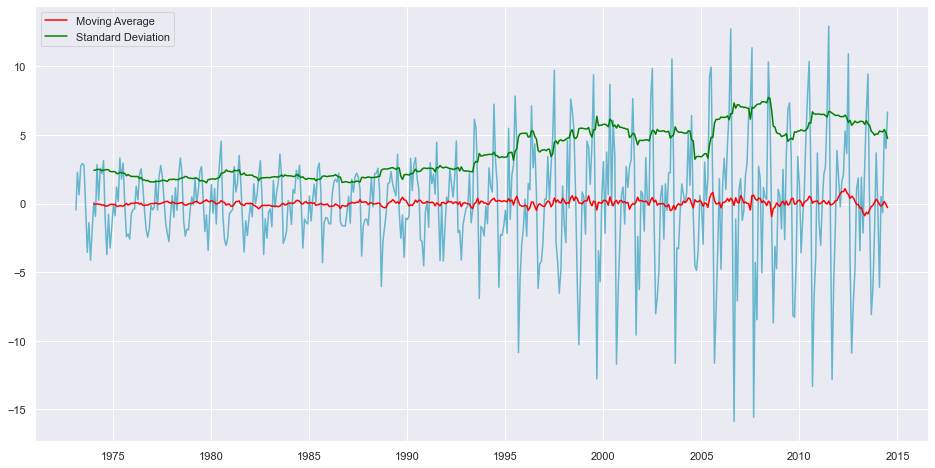

In [257]:
plt.figure(figsize=(16,8))
df_shift = df_train - df_train.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observation**
- **The mean and the standard deviation seem to be constant over time.** Let us use the adfuller test to check the stationarity.

In [258]:
# Let's confirm stationarity of residual values with adfuller test
def adfuller(data):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller

  print('Dickey-Fuller Test: ')
  adftest = adfuller(data)
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)

adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic         -5.844470e+00
p-value                 3.711348e-07
Lags Used               1.800000e+01
No. of Observations     4.790000e+02
Critical Value (1%)    -3.444076e+00
Critical Value (5%)    -2.867593e+00
Critical Value (10%)   -2.569994e+00
dtype: float64


**Observation**
- From the above test, we can see that the **p-value is very close to 0, much smaller than 0.05, therefore, **we reject the null hypothesis and confirmed that the residual values are stationary**

<Figure size 1152x576 with 0 Axes>

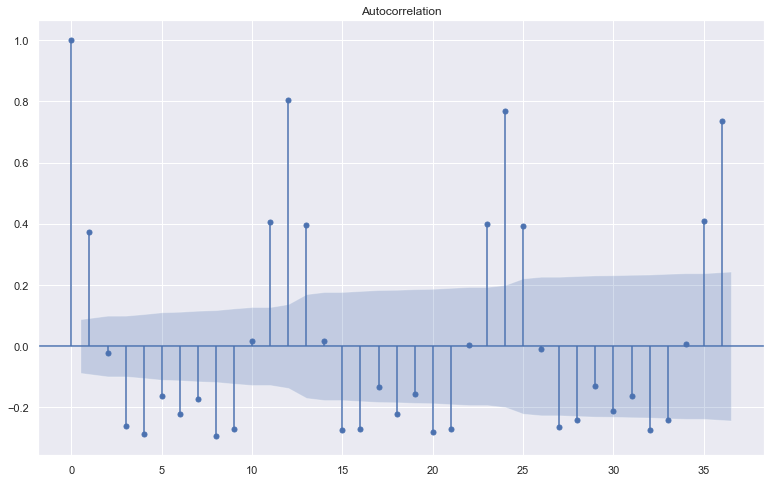

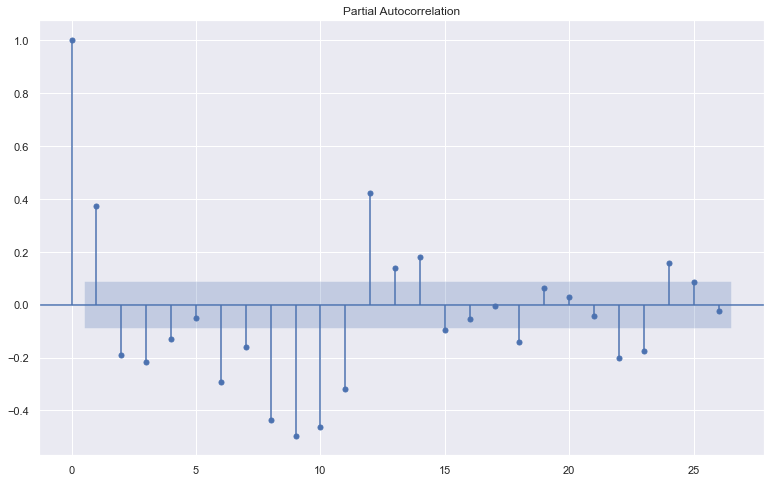

In [259]:
# Let's now plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 36) 
plt.show()
plot_pacf(df_shift, lags = 26) 
plt.show()

**Observation**
- To interpret these plots, I refered to 'ACF/PACF Plot' cheatsheet which I found in the below link

    - https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali/
    <br/><br/>
- Although not quite, the cheatsheet suggests that the plots indicate our data behaves similar to Seasonal ARIMA(SARIMA) model with an AR(1) component as I could find the below patterns from the plots 
    - ACF : Geometric Decay at each 12 lag
    - PACF : Significant at each 12 lag
<br/><br/>
- As for p and q values, they will be decided on my next step below

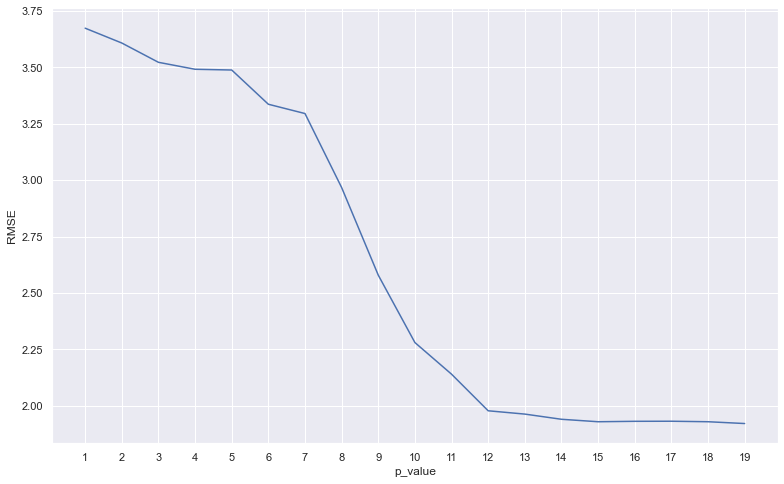

In [260]:
def Plot_AR_rmse_over_p(df):

    rmse_over_p = []
    pvalue = []

    for n in np.arange(1,20):
        model_AR = AutoReg(df, lags=n) 
        results_AR = model_AR.fit() 
        predict = results_AR.predict(start=0,end=len(df)-1) 
        predict = predict.fillna(0) 
        rmse = mean_squared_error(predict,df['Value_num'], squared=False)
        rmse_over_p.append(rmse)
        pvalue.append(n)
        
    dfrmse = pd.DataFrame(rmse_over_p, columns = ['RMSE'])
    dfrmse['p_value'] = pvalue
    sns.lineplot(x=dfrmse.p_value, y=dfrmse.RMSE)
    plt.xticks(np.arange(1,20))
    
Plot_AR_rmse_over_p(df_shift)


**Observations:**

- We can observe an ankle shape in above RMSE over p_value plot. There is a big drop of RMSE in lag 12 and it remains to be a constant afterwards. Therefore I will use p = 12 for my AR model

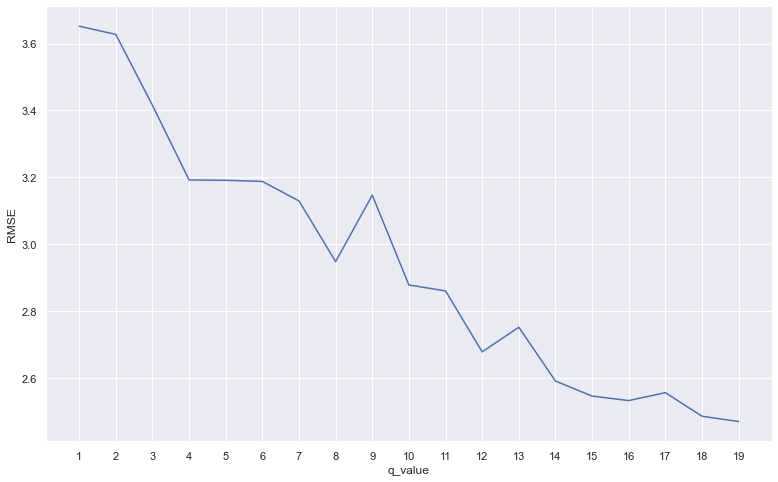

In [261]:
def Plot_MA_rmse_over_p(df):

    rmse_over_q = []
    qvalue = []

    for n in np.arange(1,20):
        model_MA = ARIMA(df_shift, order=(0, 0, n)) 
        results_MA = model_MA.fit()
        rmse_over_q.append(mean_squared_error(results_MA.fittedvalues,df_shift['Value_num'], squared=False))
        qvalue.append(n)
        
    dfrmse = pd.DataFrame(rmse_over_q, columns = ['RMSE'])
    dfrmse['q_value'] = qvalue
    sns.lineplot(x=dfrmse.q_value, y=dfrmse.RMSE)
    plt.xticks(np.arange(1,20))

Plot_MA_rmse_over_p(df_shift)

**Observations:**

-Ankle point is not clear for q value. This is expected as the ACF plot did decay very slowly indicating that MA model will not fit our data very well. For the purpose of my MA building, I will use q = 12


### **Now let's build the models and compare the results!!**

In [262]:
#setting up a list that will store test results
results = []

### **AR Model p = 12**


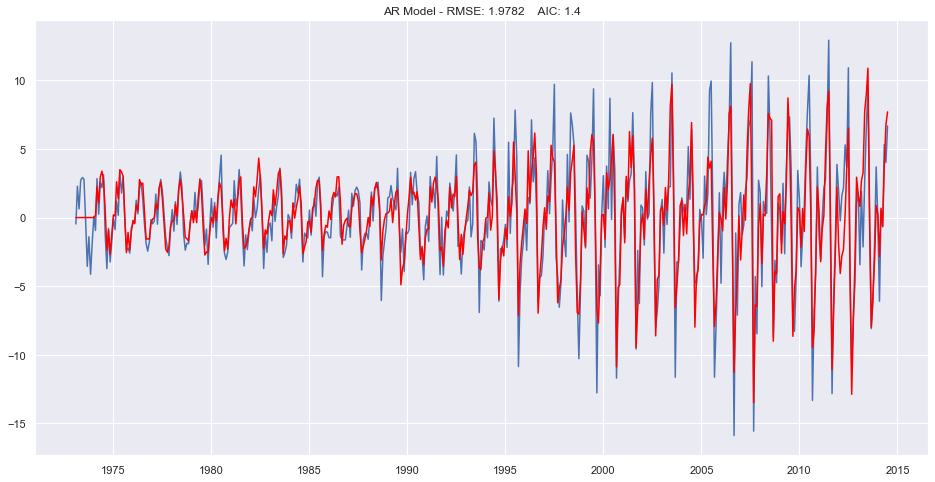

In [263]:
plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=12)
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
rmse = mean_squared_error(predict,df_shift['Value_num'], squared=False)
aic = results_AR.aic
dic = {'Model': 'AR', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('AR Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic )  #Calculating rmse
plt.show()

### **MA Model q = 12**
- We will be using an ARIMA model with p=0 and d=0 so that it will work as an MA model

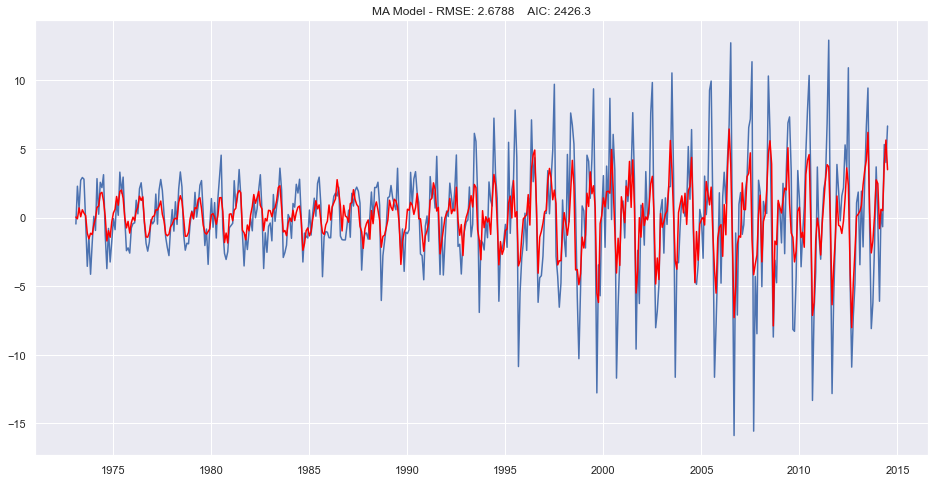

In [264]:
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 12)) 
results_MA = model_MA.fit()
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
rmse = mean_squared_error(results_MA.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_MA.aic
dic = {'Model': 'MA', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('MA Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic )  
plt.show()

### **ARMA Model p = 12, q = 12**
- We will be using an ARIMA model with d=0 so that it will work as an ARMA model

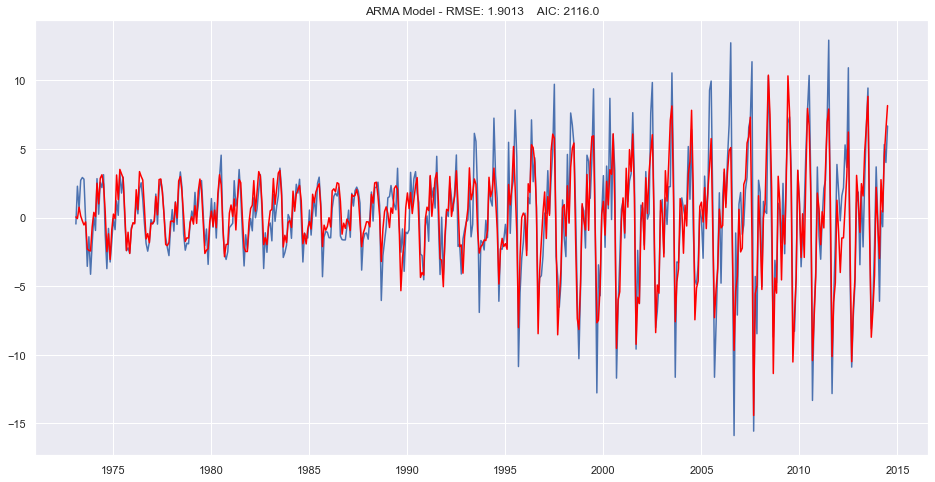

In [265]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(12, 0, 12)) 
results_ARMA = model_ARMA.fit()
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
rmse = mean_squared_error(results_ARMA.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_ARMA.aic
dic = {'Model': 'ARMA', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('ARMA Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

### **ARIMA Model p=12, d=1, q=12**
- I will try out ARIMA with d = 1 and d=2 and store them in my result list

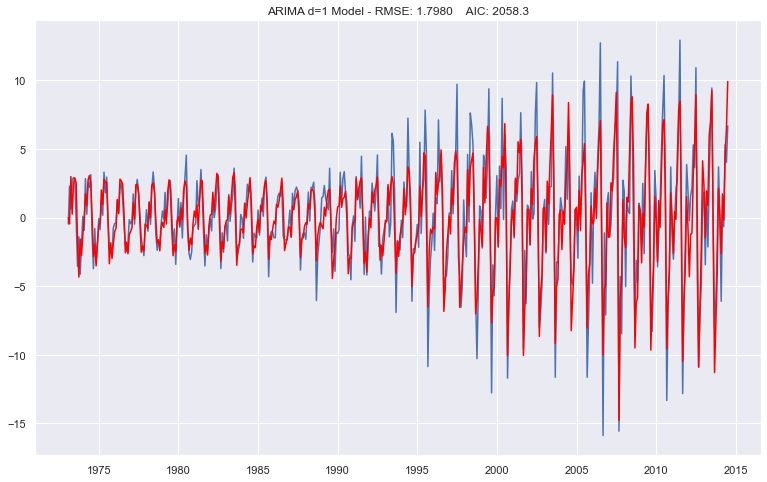

In [266]:
model_ARIMA = ARIMA(df_shift, order=(12, 1, 12)) 
results_ARIMA = model_ARIMA.fit()
plt.plot(df_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
rmse = mean_squared_error(results_ARIMA.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_ARIMA.aic
dic = {'Model': 'ARIMA d=1', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('ARIMA d=1 Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

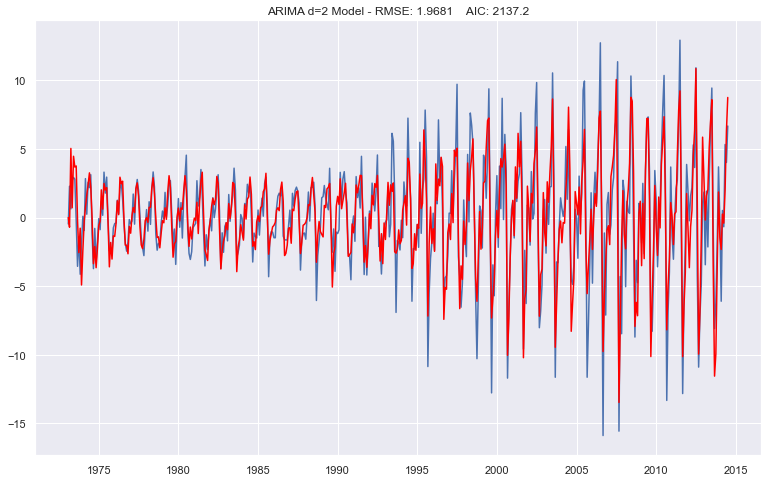

In [267]:
model_ARIMA2 = ARIMA(df_shift, order=(12, 2, 12)) 
results_ARIMA2 = model_ARIMA2.fit()
plt.plot(df_shift)
plt.plot(results_ARIMA2.fittedvalues, color='red')
rmse = mean_squared_error(results_ARIMA2.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_ARIMA2.aic
dic = {'Model': 'ARIMA d=2', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('ARIMA d=2 Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

### **SARIMAX Model**
- I will try SARIMAX model with 3 different set of (P,D,Q,M) parameters
1. (1,1,0,12)
2. (1,1,1,12)
3. (11,1,11,12)

- d-value is set to 1 as it showed better result in above ARIMA model

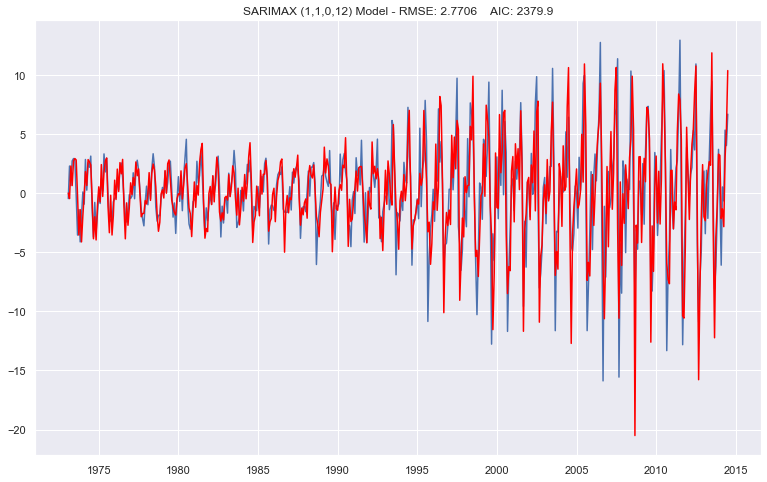

In [268]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_shift['Value_num'],order=(1, 1, 0),seasonal_order=(1,1,0,12))
results_SARIMAX =model.fit()
plt.plot(df_shift)
plt.plot(results_SARIMAX.fittedvalues, color='red')
rmse = mean_squared_error(results_SARIMAX.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_SARIMAX.aic
dic = {'Model': 'SARIMAX (1,1,0,12)', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('SARIMAX (1,1,0,12) Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

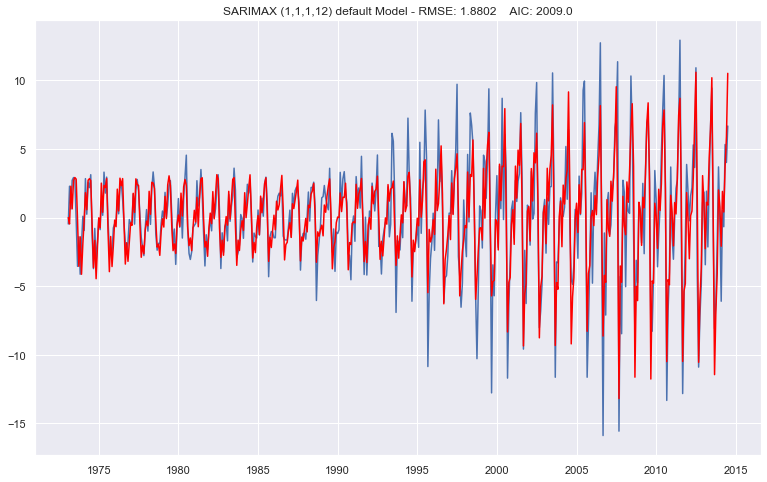

In [269]:
model2=sm.tsa.statespace.SARIMAX(df_shift['Value_num'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_SARIMAX2 =model2.fit()
plt.plot(df_shift)
plt.plot(results_SARIMAX2.fittedvalues, color='red')
rmse = mean_squared_error(results_SARIMAX2.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_SARIMAX2.aic
dic = {'Model': 'SARIMAX (1,1,1,12)', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('SARIMAX (1,1,1,12) default Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

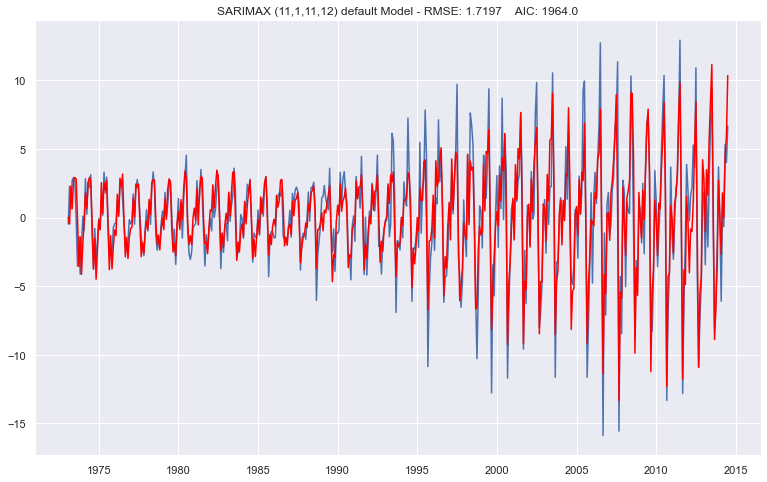

In [270]:
model3=sm.tsa.statespace.SARIMAX(df_shift['Value_num'],order=(11, 1, 11),seasonal_order=(1,1,1,12))
results_SARIMAX3 =model3.fit()
plt.plot(df_shift)
plt.plot(results_SARIMAX3.fittedvalues, color='red')
rmse = mean_squared_error(results_SARIMAX3.fittedvalues,df_shift['Value_num'], squared=False)
aic = results_SARIMAX3.aic
dic = {'Model': 'SARIMAX (11,1,11,12)', 'RMSE' : np.round(rmse,4), 'AIC': np.round(aic,1)}
results.append(dic)
plt.title('SARIMAX (11,1,11,12) default Model - RMSE: %.4f'% rmse + '    AIC: %.1f'% aic ) 
plt.show()

**Now, let's compare the results and decide on which model to pick**

In [271]:
df_result =  pd.DataFrame(results)
df_result


,Model,RMSE,AIC
0,AR,1.9782,1.4
1,MA,2.6788,2426.3
2,ARMA,1.9013,2116.0
3,ARIMA d=1,1.7980,2058.3
4,ARIMA d=2,1.9681,2137.2
5,"SARIMAX (1,1,0,12)",2.7706,2379.9
6,"SARIMAX (1,1,1,12)",1.8802,2009.0
7,"SARIMAX (11,1,11,12)",1.7197,1964.0


**Observation**
-  From above chart, we can see that my SARIMAX (11,1,11,12) performed the best with lowest RMSE and AIC values. Therefore I will move forward with this model.

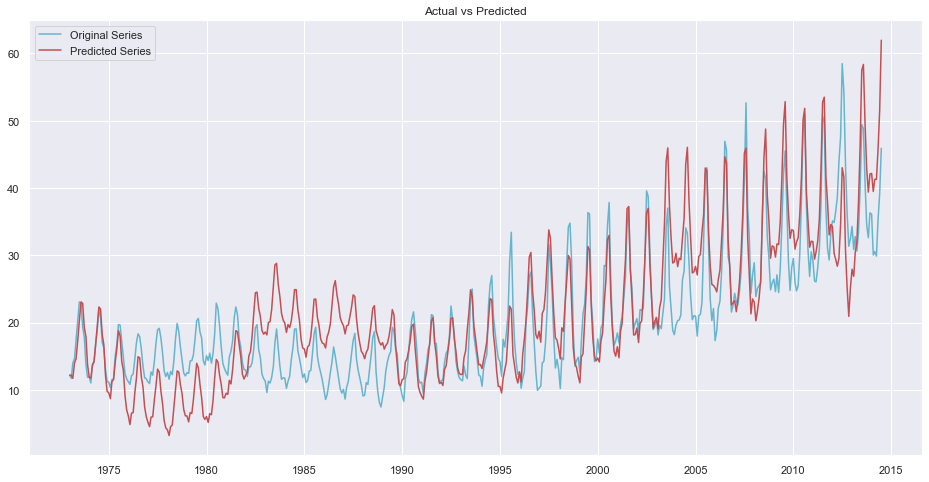

In [280]:
predictions=results_SARIMAX3.fittedvalues
predictions_cumsum = predictions.cumsum()
predictions_SARIMAX3 = pd.Series(df_train['Value_num'].iloc[0], index=df_train.index)
predictions_SARIMAX3 = predictions_SARIMAX3.add(predictions_cumsum, fill_value=0)

plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')
plt.plot(predictions_SARIMAX3, color = 'r', label = 'Predicted Series')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


**Observation**
- The model seems to be performing quite well in training data set. Now let's try to forecast using this model

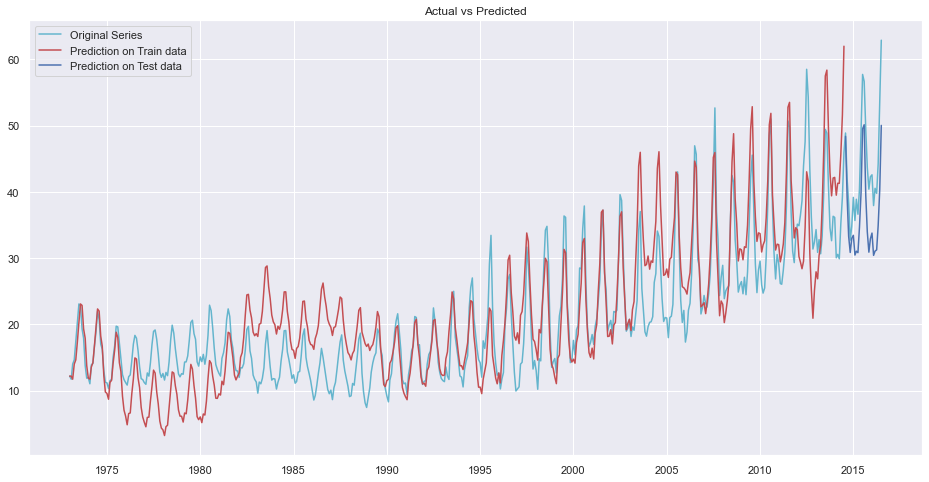

In [281]:
forecasted_SARIMAX = results_SARIMAX3.forecast(steps=24) 
forecasted_cumsum = forecasted_SARIMAX.cumsum()
index = df_test.index
df1 = pd.DataFrame()
df1['cumsum'] = forecasted_cumsum
df1.index = index

df1['Forecasted'] = df1['cumsum'] + float(df_train.loc['2014-07-01'])
forecasted_SARIMAX3 = df1['Forecasted']

plt.figure(figsize=(16,8))
plt.plot(dff, color = 'c', label = 'Original Series')
plt.plot(predictions_SARIMAX3, color = 'r', label = 'Prediction on Train data')
plt.plot(forecasted_SARIMAX3, label = 'Prediction on Test data', color='b')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [282]:
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(predictions_SARIMAX3, df_train, squared = False)
test_error = mean_squared_error(forecasted_SARIMAX3, df_test, squared = False)
print("MSE on Train Dataset : ",np.round(train_error,2))
print("MSE on Test Dataset : ",np.round(test_error,2))

MSE on Train Dataset :  5.6
MSE on Test Dataset :  7.94
